In [99]:
file_name = 'C:\\Projects\\Matlab\\I2T\\ID_01b.jpg'

In [175]:
#from skimage import io
from skimage.measure import label, regionprops
from skimage.feature import canny
from skimage.transform import (rotate, hough_line, probabilistic_hough_line)
from skimage import io, color, morphology, filters
import matplotlib.pyplot as plt

def SFZ(file_name):
    img = io.imread(file_name)
    bw = color.rgb2gray(img)

    val = filters.threshold_otsu(bw)
    bw = bw > val
    #%% alignment
    se0 = np.ones([11,11])              # dilate to connect all words at the same line
    se1 = np.ones([35,35])              # dilate to connect all words at the same line

    #bw = morphology.binary_opening(bw, se0) #.astype(np.uint8)

    bw = morphology.binary_opening(bw, se0)
    bw = morphology.binary_closing(bw, se0)
    bw = morphology.binary_closing(bw, se1)
    bw = morphology.binary_closing(bw, se1)

    label_img = label(bw, connectivity=2, background=0)
    props = regionprops(label_img)
    
    index = 0
    id_ratio = 2/3
    closest_ratio = 1
    for i in np.arange(len(props)):
        blob = props[i]
        ratio = blob.minor_axis_length/blob.major_axis_length
        print('orientation', blob.orientation)
        if blob.area > 10000:
            if abs(closest_ratio - id_ratio) > abs(ratio - id_ratio):
                closest_ratio = ratio
                index = i
    bw = label_img == index + 1 # label index is 1 based, props is 0 based
    
    edges = canny(bw, 1)

    lines = probabilistic_hough_line(edges, threshold=10, line_length=100, line_gap=10)

    fig2, ax = plt.subplots(1, 4, figsize=(12, 3))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(bw, cmap=plt.cm.gray)
    ax[1].set_title('Canny edges')
    ax[1].axis('image')

    ax[2].imshow(edges * 0)

    print('first line', lines[0])

    for line in lines:
        p0, p1 = line
        ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

    ax[2].set_title('Probabilistic Hough')
    ax[2].axis('image')

    max_norm = 0;
    max_index = 0;
    cur_index = 0;
    for line in lines:
        p0, p1 = line
        norm = np.linalg.norm((np.array(p0)-np.array(p1)))
        if norm > max_norm:
            max_norm = norm
            max_index = cur_index
        cur_index += 1

    p0, p1 = lines[max_index]
    base_vec = (np.array(p1)-np.array(p0))/max_norm
    normal_vec = np.array([-base_vec[1], base_vec[0]])
    #print('base_vec', base_vec)
    #print('normal vec', normal_vec)
    base_pt = np.array(p0)

    t_max = -np.inf
    t_min = np.inf
    s_max = -np.inf
    s_min = np.inf
    for line in lines:
        p0, p1 = line
        vec = np.array(p0)-base_pt

        t = np.dot(vec, base_vec)
        if t > t_max:
            t_max = t
        elif t < t_min:
            t_min = t

        s = np.dot(vec, normal_vec)
        if s > s_max:
            s_max = s
        elif s < s_min:
            s_min = s
    '''
    print('t min', t_min)
    print('t max', t_max)
    print('s min', s_min)
    print('s max', s_max)
    ''' 

    p0 = np.int16(base_pt + t_min*base_vec + s_min*normal_vec);
    p1 = np.int16(base_pt + t_max*base_vec + s_min*normal_vec);
    p2 = np.int16(base_pt + t_max*base_vec + s_max*normal_vec);
    p3 = np.int16(base_pt + t_min*base_vec + s_max*normal_vec);

    '''
    print('p0', np.int16(p0))
    print('p1', np.int16(p1))
    print('p2', np.int16(p2))
    print('p3', np.int16(p3))
    '''

    '''
    print('x range', x_min, x_max)
    print('y range', y_min, y_max)
    '''

    if t_max - t_min >= s_max - s_min:
        half_w = np.int16(0.5*(t_max - t_min))
        half_h = np.int16(0.5*(s_max - s_min))
        theta = np.arccos(np.clip(np.dot(base_vec, np.array([1,0])), -1.0, 1.0))
    else:
        half_h = np.int16(0.5*(t_max - t_min))
        half_w = np.int16(0.5*(s_max - s_min))
        theta = np.arccos(np.clip(np.dot(normal_vec, np.array([1,0])), -1.0, 1.0))

    half_w = max(half_w-1, 0)
    half_h = max(half_h-1, 0)

    theta = 180*theta/3.1416
    print(theta)
    
    rotate_angle = 180-theta
    if theta < 90:
        rotate_angle = -theta

    x_min = min(p0[0], p1[0], p2[0], p3[0])
    x_max = max(p0[0], p1[0], p2[0], p3[0])
    y_min = min(p0[1], p1[1], p2[1], p3[1])
    y_max = max(p0[1], p1[1], p2[1], p3[1])

    id_cropped = img[y_min:y_max, x_min:x_max]
    id_aligned = rotate(id_cropped, rotate_angle, resize=True)

    dim = id_aligned.shape
    ctr_x = np.int16(0.5*dim[1])
    ctr_y = np.int16(0.5*dim[0])

    id_cropped = id_aligned[ctr_y-half_h:ctr_y+half_h, ctr_x-half_w:ctr_x+half_w, :]
    
    ax[3].imshow(id_cropped)
    plt.show()
    
    return id_cropped

orientation 0.24665837002224025
orientation -0.0019179764590875497
first line ((283, 399), (599, 326))
13.0601570395


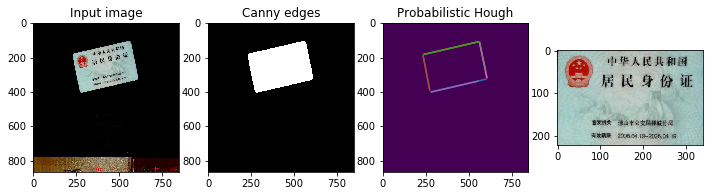

In [176]:
cropped_id = SFZ('C:\\Projects\\Matlab\\I2T\\ID_06b.jpg')